In [86]:
from cleaning import database_cleaner

from pprint import pprint
import string
import re

# Gensim
import gensim
from gensim.models import CoherenceModel
from gensim import models, corpora
from gensim import similarities

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK
from nltk.corpus import stopwords
from nltk import word_tokenize

# spacy for lemmatization
import spacy

In [91]:
def get_data(filename):
    """Load raw data from a file and return vectorizer and feature_matrix.
    Parameters
    ----------
    filename: The path to a json file containing the university database.
    Returns
    -------
    corpus: A numpy array containing abstracts.
    """
    df_cleaned = database_cleaner(filename)

    # For nlp, only retaining faculty_name, research_areas, paper_titles, abstracts
    df_filtered = df_cleaned[['faculty_name', 'research_areas', 'paper_titles', 'abstracts']]
    missing = df_filtered['paper_titles'] == ''
    num_missing = sum(missing)
    print(f'{num_missing} faculties have missing papers in {filename}')
    print('Running nlp-pipeline on faculties with non-missing papers...')

    df_nlp = df_filtered[~missing]

    # Choosing abstracts and paper_titles to predict topics for a professor
    data = (df_nlp['paper_titles'] + df_nlp['abstracts']).values

    return data

data = get_data('../data/pge_database.json')

0 faculties have missing papers in ../data/pge_database.json
Running nlp-pipeline on faculties with non-missing papers...


In [92]:
data.shape

(75,)

In [95]:
# NLTK Stop words
stopwords_ = stopwords.words('english')

def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in stopwords_ and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return cleaned_text
 
# For gensim we need to tokenize the data and filter out stopwords
tokens_filtered = []
for text in data:
    tokens_filtered.append(clean_text(text))

# def filter_tokens(sent):
#     return([w for w in sent if not w in stopwords_ and not w in punctuation_ and re.match('[a-zA-Z-][a-zA-Z-]{2,}]', w)])

# tokens = [word_tokenize(doc) for doc in corpus]
# tokens_lower = [[word.lower() for word in sent] for sent in tokens]
# tokens_filtered = list(map(filter_tokens, tokens_lower))

In [96]:
# Build the bigram and trigram models
import warnings
warnings.filterwarnings("ignore",category=UserWarning)

bigram = gensim.models.Phrases(tokens_filtered, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokens_filtered], threshold=100) 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [97]:
# Form Bigrams
tokens_bigrams = make_bigrams(tokens_filtered)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(tokens_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [114]:
n_topics = 9

# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(tokens_filtered)

In [115]:
# Transform the collection of texts to a numerical form [(word_id, count), ...]
corpus = [dictionary.doc2bow(text) for text in tokens_filtered]

In [129]:
tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary) # tfidf gives better coherence score

lda_model = gensim.models.ldamodel.LdaModel(tfidf_model[corpus], id2word=dictionary, num_topics=n_topics)

# Build the LDA model
# lda_model = models.LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)
 
# Build the LSI model
lsi_model = models.LsiModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)

In [117]:
print("LDA Model:")
 
for idx in range(n_topics):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
 
print("=" * 20)
 
print("LSI Model:")
 
for idx in range(n_topics):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 10))
 
print("=" * 20)

LDA Model:
Topic #0: 0.009*"gas" + 0.008*"oil" + 0.007*"fracture" + 0.007*"model" + 0.006*"flow" + 0.006*"production" + 0.006*"pressure" + 0.005*"reservoir" + 0.005*"well" + 0.005*"water"
Topic #1: 0.007*"using" + 0.007*"fracture" + 0.006*"model" + 0.006*"oil" + 0.006*"flow" + 0.006*"reservoir" + 0.006*"well" + 0.005*"gas" + 0.005*"used" + 0.005*"method"
Topic #2: 0.007*"fracture" + 0.007*"oil" + 0.007*"model" + 0.006*"reservoir" + 0.006*"well" + 0.006*"gas" + 0.005*"results" + 0.005*"production" + 0.004*"data" + 0.004*"used"
Topic #3: 0.010*"reservoir" + 0.009*"gas" + 0.009*"model" + 0.008*"oil" + 0.007*"well" + 0.007*"flow" + 0.006*"fracture" + 0.006*"reservoirs" + 0.006*"using" + 0.006*"production"
Topic #4: 0.009*"reservoir" + 0.008*"model" + 0.008*"gas" + 0.007*"fracture" + 0.006*"production" + 0.006*"oil" + 0.006*"used" + 0.006*"flow" + 0.006*"results" + 0.005*"reservoirs"
Topic #5: 0.009*"oil" + 0.009*"model" + 0.007*"fracture" + 0.006*"reservoir" + 0.006*"results" + 0.006*"usin

In [ ]:
text = "Steam injection is a widely used oil-recovery method that has been commercially successful in many types of heavy-oil reservoirs, including the oil sands of Alberta, Canada. Steam is very effective in delivering heat that is the key to heavy-oil mobilization. In the distant past in California, and also recently in Alberta, solvents were/are being used as additives to steam for additional viscosity reduction. The current applications are in field projects involving steam-assisted gravity drainage (SAGD) and cyclic steam stimulation (CSS).The past and present projects using solvents alone or in combination with steam are reviewed and evaluated, including enhanced solvent SAGD (ES-SAGD) and liquid addition to steam for enhancing recovery (LASER). The use of solvent in other processes, such as effective solvent extraction incorporating electromagnetic heating (ESEIEH) and after cold-heavy-oil production with sand (CHOPS), are also reviewed. The theories behind the use of solvents with steam are outlined. These postulate additional heavy-oil/bitumen mobilization; oil mobilization ahead of the steam front; and oil mobilization by solvent dispersion caused by frontal instability. The plausibility of the different approaches and solvent availability and economics are also discussed."
bow = dictionary.doc2bow(clean_text(text))
 
print(lsi_model[bow])

print(lda_model[bow])

In [ ]:
# Querying
lda_index = similarities.MatrixSimilarity(lda_model[corpus])
 
# Let's perform some queries
similarities = lda_index[lda_model[bow]]
# Sort the similarities
similarities = sorted(enumerate(similarities), key=lambda item: -item[1])
 
# Top most similar documents:
print(similarities[:10])
# [(104, 0.87591344), (178, 0.86124849), (31, 0.8604598), (77, 0.84932965), (85, 0.84843522), (135, 0.84421808), (215, 0.84184396), (353, 0.84038532), (254, 0.83498049), (13, 0.82832891)]
 
# Let's see what's the most similar document
document_id, similarity = similarities[0]
print(corpus[document_id][:1000])

In [130]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens_filtered, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.061936835

Coherence Score:  0.437129010619


In [137]:
# LDA Mallet (slower)
mallet_path = '~/Documents/GitHub/capstone/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=n_topics, id2word=dictionary, prefix='~/Documents/Github/capstone/')

In [132]:
# Show Topics
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=tokens_filtered, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.504408584554


# Choosing number of topics

In [122]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [133]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokens_filtered, start=5, limit=21, step=2)

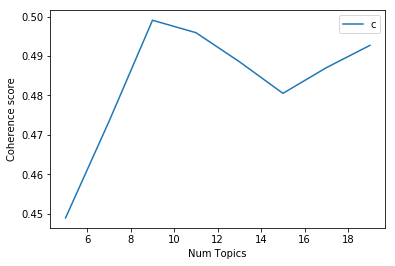

In [134]:
# Show graph
limit=21; start=5; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [135]:
# Print the coherence scores (9 seems to be optimal here)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.4489
Num Topics = 7  has Coherence Value of 0.4734
Num Topics = 9  has Coherence Value of 0.4991
Num Topics = 11  has Coherence Value of 0.4959
Num Topics = 13  has Coherence Value of 0.4885
Num Topics = 15  has Coherence Value of 0.4805
Num Topics = 17  has Coherence Value of 0.4871
Num Topics = 19  has Coherence Value of 0.4927


In [136]:
# Visualize the topics with simple lda model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, numerical_corpus, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      46.844734        1       1 -0.000351  0.001441
6      28.237810        1       2  0.002916 -0.000459
5      20.943893        1       3 -0.000770  0.000551
2       1.896839        1       4 -0.000153  0.000346
3       0.915257        1       5 -0.001126 -0.002080
8       0.851137        1       6 -0.000145  0.000277
4       0.306882        1       7 -0.000480 -0.000035
0       0.001719        1       8 -0.000127 -0.000032
1       0.001719        1       9  0.000237 -0.000009, topic_info=      Category        Freq                  Term       Total  loglift  logprob
term                                                                          
24     Default   57.000000                  acid   57.000000  30.0000  30.0000
989    Default  106.000000              fracture  106.000000  29.0000  29.0000
5457   Default   55.000000                  foam   55.000000  28.0000  28.0000
434    Default   54.000000          conductivity   54.000000  27.0000  27.0000
3800   Default   60.000000            combustion   60.000000  26.0000  26.0000
293    Default   62.000000                casing   62.000000  25.0000  25.0000
5150   Default   61.000000            surfactant   61.000000  24.0000  24.0000
1759   Default   60.000000               polymer   60.000000  23.0000  23.0000
1864   Default   51.000000              proppant   51.000000  22.0000  22.0000
304    Default   93.000000                cement   93.000000  21.0000  21.0000
1300   Default   38.000000               jetting   38.000000  20.0000  20.0000
2287   Default   64.000000                stress   64.000000  19.0000  19.0000
999    Default   70.000000             fractures   70.000000  18.0000  18.0000
3584   Default   52.000000                 steam   52.000000  17.0000  17.0000
1615   Default   66.000000                   oil   66.000000  16.0000  16.0000
2616   Default   39.000000              wormhole   39.000000  15.0000  15.0000
5695   Default   56.000000         nanoparticles   56.000000  14.0000  14.0000
8107   Default   38.000000                   asp   38.000000  13.0000  13.0000
2590   Default   54.000000              wellbore   54.000000  12.0000  12.0000
1029   Default   68.000000                   gas   68.000000  11.0000  11.0000
2596   Default   56.000000                 wells   56.000000  10.0000  10.0000
2326   Default   45.000000           surfactants   45.000000   9.0000   9.0000
2136   Default   62.000000                 shale   62.000000   8.0000   8.0000
1719   Default   56.000000          permeability   56.000000   7.0000   7.0000
5452   Default   56.000000              flooding   56.000000   6.0000   6.0000
5453   Default   41.000000                floods   41.000000   5.0000   5.0000
1156   Default   53.000000            imbibition   53.000000   4.0000   4.0000
2353   Default   41.000000           temperature   41.000000   3.0000   3.0000
1227   Default   52.000000             injection   52.000000   2.0000   2.0000
221    Default   46.000000              borehole   46.000000   1.0000   1.0000
...        ...         ...                   ...         ...      ...      ...
14695   Topic9    0.000656                   ucs   20.930006   0.6008  -9.4224
15449   Topic9    0.000651  wettability-altering   21.012218   0.5882  -9.4310
6973    Topic9    0.000778            high-angle   25.200832   0.5857  -9.2518
7019    Topic9    0.000765                kernel   24.803162   0.5843  -9.2691
6252    Topic9    0.000719                 blend   23.460533   0.5780  -9.3310
6745    Topic9    0.000695             anhydrite   23.155996   0.5571  -9.3650
5730    Topic9    0.000789                  ooip   26.438707   0.5516  -9.2379
19061   Topic9    0.000623                   egs   20.886694   0.5514  -9.4738
6380    Topic9    0.000782                gypsum   26.443991   0.5426  -9.2467
5460    Topic9    0.000649               foam

# Visualizing best lda_mallet model
* Code taken from: https://github.com/jerielizabeth/Gospel-of-Health-Notebooks/blob/master/blogPosts/pyLDAvis_and_Mallet.ipynb

In [145]:
import gzip
import os
import pandas as pd

dataDir = "/Users/Neha/Documents/GitHub/capstone"

def extract_params(statefile):
    """Extract the alpha and beta values from the statefile.

    Args:
        statefile (str): Path to statefile produced by MALLET.
    Returns:
        tuple: alpha (list), beta    
    """
    with gzip.open(statefile, 'r') as state:
        params = [x.decode('utf8').strip() for x in state.readlines()[1:3]]
    return (list(params[0].split(":")[1].split(" ")), float(params[1].split(":")[1]))


def state_to_df(statefile):
    """Transform state file into pandas dataframe.
    The MALLET statefile is tab-separated, and the first two rows contain the alpha and beta hypterparamters.
    
    Args:
        statefile (str): Path to statefile produced by MALLET.
    Returns:
        datframe: topic assignment for each token in each document of the model
    """
    return pd.read_csv(statefile,
                       compression='gzip',
                       sep=' ',
                       skiprows=[1,2]
                       )


In [146]:
params = extract_params(os.path.join(dataDir, 'state.mallet.gz'))

In [147]:
alpha = [float(x) for x in params[0][1:]]
beta = params[1]
print("{}, {}".format(alpha, beta))

[5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555], 0.01


In [148]:
df = state_to_df(os.path.join(dataDir, 'state.mallet.gz'))

In [149]:
df['type'] = df.type.astype(str)
df[:10]

,#doc,source,pos,typeindex,type,topic
0,0,NaN,0,0,-based,1
1,0,NaN,1,1,-scan,1
2,0,NaN,2,2,ability,0
3,0,NaN,3,2,ability,0
4,0,NaN,4,2,ability,0
5,0,NaN,5,3,absence,0
6,0,NaN,6,4,abstract,1
7,0,NaN,7,4,abstract,5
8,0,NaN,8,4,abstract,1
9,0,NaN,9,4,abstract,1


In [150]:
# Get document lengths from statefile
docs = df.groupby('#doc')['type'].count().reset_index(name ='doc_length')

docs[:10]

,#doc,doc_length
0,0,14767
1,1,6476
2,2,2975
3,3,9746
4,4,1732
5,5,10177
6,6,858
7,7,10449
8,8,7576
9,9,2841


In [151]:
# Get vocab and term frequencies from statefile
vocab = df['type'].value_counts().reset_index()
vocab.columns = ['type', 'term_freq']
vocab = vocab.sort_values(by='type', ascending=True)

vocab[:10]

,type,term_freq
20383,-acetamide,1
11428,-acetate-hpam,2
4186,-based,11
19680,-benzoic,1
20298,-both,1
17261,-cost-effective,1
14381,-cpmg,1
13467,-density,1
11178,-derived,2
10217,-ethylenediaminetriacetic,2


In [153]:
#  Topic-term matrix from state file
# https://ldavis.cpsievert.me/reviews/reviews.html

import sklearn.preprocessing

def pivot_and_smooth(df, smooth_value, rows_variable, cols_variable, values_variable):
    """
    Turns the pandas dataframe into a data matrix.
    Args:
        df (dataframe): aggregated dataframe 
        smooth_value (float): value to add to the matrix to account for the priors
        rows_variable (str): name of dataframe column to use as the rows in the matrix
        cols_variable (str): name of dataframe column to use as the columns in the matrix
        values_variable(str): name of the dataframe column to use as the values in the matrix
    Returns:
        dataframe: pandas matrix that has been normalized on the rows.
    """
    matrix = df.pivot(index=rows_variable, columns=cols_variable, values=values_variable).fillna(value=0)
    matrix = matrix.values + smooth_value
    
    normed = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    
    return pd.DataFrame(normed)

In [154]:
phi_df = df.groupby(['topic', 'type'])['type'].count().reset_index(name ='token_count')
phi_df = phi_df.sort_values(by='type', ascending=True)

phi_df[:10]

,topic,type,token_count
23667,7,-acetamide,1
16938,5,-acetate-hpam,2
23668,7,-based,1
3251,1,-based,2
0,0,-based,8
13485,4,-benzoic,1
1,0,-both,1
23669,7,-cost-effective,1
20754,6,-cpmg,1
10276,3,-density,1


In [155]:
phi = pivot_and_smooth(phi_df, beta, 'topic', 'type', 'token_count')

In [156]:
theta_df = df.groupby(['#doc', 'topic'])['topic'].count().reset_index(name ='topic_count')

theta_df[:10]

,#doc,topic,topic_count
0,0,0,1372
1,0,1,11891
2,0,2,39
3,0,3,91
4,0,4,161
5,0,5,416
6,0,6,108
7,0,7,616
8,0,8,73
9,1,0,84


In [157]:
theta = pivot_and_smooth(theta_df, alpha , '#doc', 'topic', 'topic_count')

In [158]:
import pyLDAvis

data = {'topic_term_dists': phi, 
        'doc_topic_dists': theta,
        'doc_lengths': list(docs['doc_length']),
        'vocab': list(vocab['type']),
        'term_frequency': list(vocab['term_freq'])
       }

In [159]:
vis_data = pyLDAvis.prepare(**data)

In [160]:
vis_data

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      19.874859        1       1 -0.054570 -0.073084
1      15.185597        1       2  0.029973 -0.073392
3      13.344299        1       3  0.060355  0.111999
5      13.122838        1       4 -0.117135 -0.046510
0      10.221756        1       5  0.167116  0.087571
4       7.936841        1       6 -0.094011 -0.032796
8       7.711944        1       7  0.091569  0.224886
6       6.466266        1       8  0.183830 -0.233675
2       6.135601        1       9 -0.267127  0.035000, topic_info=      Category         Freq            Term        Total  loglift  logprob
term                                                                      
7006   Default  3608.000000        fracture  3608.000000  30.0000  30.0000
12699  Default  3864.000000             oil  3864.000000  29.0000  29.0000
5149   Default  1070.000000        drilling  1070.000000  28.0000  28.0000
7265   Default  3634.000000             gas  3634.000000  27.0000  27.0000
15344  Default  1699.000000        recovery  1699.000000  26.0000  26.0000
7071   Default  1519.000000       fractures  1519.000000  25.0000  25.0000
14585  Default  2719.000000      production  2719.000000  24.0000  24.0000
19473  Default   918.000000  unconventional   918.000000  23.0000  23.0000
171    Default  1110.000000            acid  1110.000000  22.0000  22.0000
16015  Default  1329.000000            rock  1329.000000  21.0000  21.0000
18193  Default   708.000000      surfactant   708.000000  20.0000  20.0000
15688  Default  3417.000000       reservoir  3417.000000  19.0000  19.0000
3289   Default   798.000000    conductivity   798.000000  18.0000  18.0000
14386  Default  2476.000000        pressure  2476.000000  17.0000  17.0000
20478  Default   838.000000        wellbore   838.000000  16.0000  16.0000
13561  Default  2032.000000    permeability  2032.000000  15.0000  15.0000
14030  Default   955.000000            pore   955.000000  14.0000  14.0000
20238  Default  1731.000000           water  1731.000000  13.0000  13.0000
5651   Default   767.000000          energy   767.000000  12.0000  12.0000
16684  Default  2001.000000           shale  2001.000000  11.0000  11.0000
11397  Default  3993.000000           model  3993.000000  10.0000  10.0000
12911  Default   656.000000    optimization   656.000000   9.0000   9.0000
10841  Default   762.000000    measurements   762.000000   8.0000   8.0000
13984  Default   607.000000         polymer   607.000000   7.0000   7.0000
17650  Default   432.000000           steam   432.000000   6.0000   6.0000
13663  Default   955.000000           phase   955.000000   5.0000   5.0000
8985   Default  1507.000000       injection  1507.000000   4.0000   4.0000
6812   Default   706.000000            foam   706.000000   3.0000   3.0000
7081   Default   909.000000      fracturing   909.000000   2.0000   2.0000
15727  Default  2218.000000      reservoirs  2218.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
12911   Topic9   277.832489    optimization   656.571552   1.9310  -4.5850
4004    Topic9    61.748298           cycle    83.746908   2.4863  -6.0890
14194   Topic9    89.630129           power   155.328485   2.2412  -5.7164
12870   Topic9    82.659671       operating   137.623521   2.2813  -5.7973
14545   Topic9    78.676553      procedures   128.546501   2.3001  -5.8467
18361   Topic9   261.900014          system   898.851571   1.5579  -4.6441
4447    Topic9   241.984421          design   812.659923   1.5796  -4.7232
14542   Topic9   114.524621       procedure   246.945043   2.0227  -5.4713
12136   Topic9    71.706095             net   119.589874   2.2796  -5.9395
14551   Topic9   258.912675         process  1065.383856   1.3765  -4.6556
7926    Topic9   119.503520            heat   290.181779   1.9039  -5.4287
2235    Topic9    92.617468         capture   234.931297   1.86